<a href="https://colab.research.google.com/github/pierretdf/image-car-classifier/blob/master/ia_car_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

L'objectif de ce projet est de prédire le marque d'une voiture à partir de son image. Une voiture est représentée par une image au format JPEG. Le dataset à été récupéré sur ce [repository](https://github.com/nicolas-gervais/predicting-car-price-from-scraped-data) github.

Ce projet porte sur la problématique de classement d'images dans différentes catégories.

# Etat de l'art

Plusieurs projets de classification véhicules existent. Certains utilisent le type de véhicule (berline, limousine,  citadine, ...), la marque du véhicule ou bien le modèle du véhicule. La plupart des projets utilisent des réseaux de neurones convolutifs (CNN) car ils sont plus adaptés à la classification d'images, voir avec un modèle pré-entraîné en utilisant une base de données comme imageNet par exemple. 

* Ce [projet](https://medium.com/@sridatta0808/deep-learning-based-vehicle-make-model-mmr-classification-on-carconnection-dataset-9bc93997041f) classifie les marques des véhicule et atteint une précision de d'environ 95% avec 41 classes en utilisant du transfert learning avec MobileNetV2 (RNN) et la base d'images imageNet.
* Par contre ce [projet](https://www.statworx.com/en/content-hub/blog/car-model-classification-1-transfer-learning-with-resnet/) atteint une précision de 70% sur plus de 300 classes en utilisant également du transfert learning avec ResNet50V2 (RNN) et la base d'images imageNet.

# Méthode

Voici les étapes de l'implémentation du modèle avec un réseau de neurones convolutif (CNN) simple :

*   importation du dataset
*   réduction de la dimension des images  
*   division du dataset en deux : entraînement et test
*   définition du modèle
*   choix de la fonction de coût et de l'algorithme d'optimisation
*   apprentissage du modèle sur le dataset d'entraînement
*   ajustement du modèle : réduction de l'overfitting
*   validation du modèle par un dataste différent  



In [1]:
# Select TF2.x as version
%tensorflow_version 2.x

In [2]:
import os
import re
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import tensorflow as tf
from keras.preprocessing.image import image
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (Dense, 
                                     GlobalAveragePooling2D, 
                                     Flatten, 
                                     Conv2D, 
                                     MaxPool2D, 
                                     Input, 
                                     Dropout,
                                     Rescaling,
                                     RandomFlip,
                                     RandomRotation,
                                     RandomZoom)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Importation du jeux de données

*   64,465 images de voitures
*   42 marques différentes constituants les classes du modèle



In [3]:
!git clone https://github.com/pierretdf/image-car-classifier

fatal: destination path 'image-car-classifier' already exists and is not an empty directory.


In [4]:
PROJECT_PATH = 'image-car-classifier'
# Set working dir
os.chdir(PROJECT_PATH)

Redimensionnement des images à [200,200,3] pour fitter avec le modèle pré-entraîné utilisé en second temps.

In [5]:
# Gobal settings
IMAGE_DIRECTORIES_DIR = 'data/car-classifier/'
IMAGE_SHAPE = (200, 200, 3)
# Use a small batch size
BATCH_SIZE = 16

## Construction du dataset avec TensorFlow

*   80% dataset d'entraînement
*   20% dataset de test



In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIRECTORIES_DIR,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIRECTORIES_DIR,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
)

Found 64465 files belonging to 42 classes.
Using 51572 files for training.
Found 64465 files belonging to 42 classes.
Using 12893 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 645
Number of test batches: 161


### Affichage des images du premier batch du dataset d'entraînement





In [8]:
# List of car makers
class_names = train_ds.class_names
print(class_names)

['acura', 'alfa romeo', 'aston martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ferrari', 'fiat', 'ford', 'genesis', 'gmc', 'honda', 'hyuandai', 'infinity', 'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mclaren', 'mercedes-benz', 'mini', 'mitsubishi', 'nissan', 'porsche', 'ram', 'rolls-royce', 'smart', 'subaru', 'tesla', 'toyota', 'volkswagen', 'volvo']


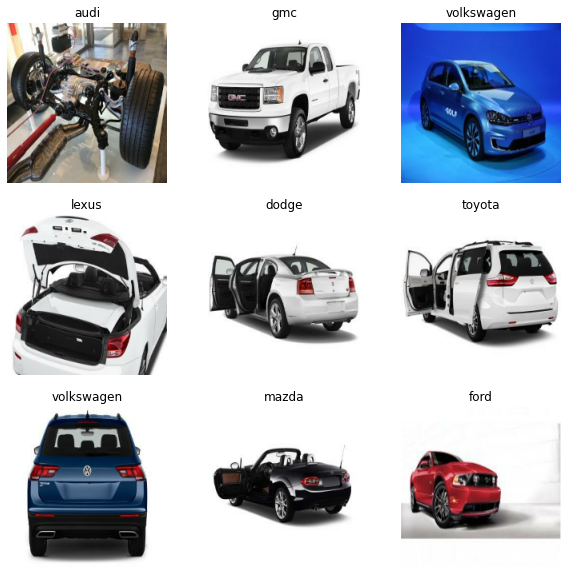

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Standardisation des données


> Permet d'améliorer les performances sur TensorFlow [Guide de performance](https://www.tensorflow.org/guide/data_performance)



In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Définition du modèle

## Réseau de neurones convolutifs (CNN)

*    Première couche d'augmentation des données `data_augmentation` afin de générer de nouvelles images d'entraînement avec des transformations aléatoires.
*    Couche de normalisation *Rescaling* pour réduire l'intervalle de pixels des images de [0,255] (RVB) à [0,1].
*   3 couches de convolutions + pooling successives avec une ReLu comme fonction d'activation.
*   x2 du nombre de couches de filtres en sortie de convolution afin de trouver les meilleurs caractéristiques (*features*) des images.
*   Une couche de désactivation (*Dropout*) qui désactive aléatoirement une portion des neurones de la couche précédente afin d'éviter l'overfitting du modèle.
*   Une couche de redimensionnement (*Flatten*) permet recaler la sortie du *Dropout* au bon format pour la couche suivante.
*   Une couche finale entièrement connectée pour redimensionner les données à la dimension des classes en sorties.





In [11]:
data_augmentation = Sequential([
    RandomFlip("horizontal",input_shape=IMAGE_SHAPE),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

model = Sequential([
  data_augmentation,
  Rescaling(1./255, input_shape=IMAGE_SHAPE),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names))
])

Compilation du modèle

*   Fonction de coût `categorical_crossentropy` : utilisée pour des modèles de classifications à multiples classes combinant le log softmax et le Negative Log-Likelihood.
*   Optimiseur `adam` : algorithme d'optimisation de la descente de gradient stochastique.





In [12]:
learning_rate = 0.00001

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

## Fonction de call back

La fonction de call back `EarlyStopping` permet d'optimiser le nombre d'epochs à réaliser par le modèle afin d'éviter le sur-ajustement. Cette fonction peut monitorer les valeurs de perte (*loss*) ou de précision (*accuracy*). Dans le modèle, la valeur de perte est surveillée par cette fonction donc le modèle s'arrête lorsqu'une augmentation est observée dans les valeurs de perte.


In [13]:
callbacks = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          patience = 5, 
                          restore_best_weights = True)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

## Entraînement du modèle

In [ ]:
epochs = 20
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[callbacks])

Epoch 1/20
2138/3224 [==================>...........] - ETA: 17s - loss: 3.4105 - accuracy: 0.0777

## Affichage de la prédiction du modèle




In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print("Trained model has a prediction accuracy of {} and a prediction loss of {}".format(acc, loss))

## Transfert Learning

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False

In [ ]:
# Pre-trained MobileNet V2 summary
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Conclusion

Je n'arrive plus a entraîner le modèle. J'ai un problème de RAM lors de l'execution de `model.fit()`. Malgré que ce soit un modèle simple sans modification des hyperparamètres, j'ai modifié quelque chose mais je ne comprends pas l'erreur.

## Perspectives d'améliorations

* Ajuster les hypermarètres : le nombre et la taille des noyaux dans chaque couche de convolution `conv2D`, la taille du `stride` et la taille des noyaux `kernel` dans les couches de polling `MaxPool2D`.
* Utiliser différents optimiseurs.
* Essayer des architectures plus complexes, comme ImageNet avec un modèle pré-entraîné comme resNet.
* Gérer l'overfitting.
* Trouver plus de données.


# Ressources

* Classement des images, [TensorFlow](https://www.tensorflow.org/tutorials/images/classification)
* Apprentissage par transfert et optimisation, [TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning)
* Deep Learning Based Vehicle Make-Model Classification on CarConnection Dataset, [Medium](https://medium.com/@sridatta0808/deep-learning-based-vehicle-make-model-mmr-classification-on-carconnection-dataset-9bc93997041f)
* 64,000 pictures of cars, labeled by make, model, year, price, horsepower, body style, etc., [Reddit](https://www.reddit.com/r/MachineLearning/comments/ek5zwv/p_64000_pictures_of_cars_labeled_by_make_model/?utm_source=share&utm_medium=ios_app&utm_name=iossmf)
* Car Model Classification I: Transfer Learning mit ResNet, [Statworx](https://www.statworx.com/en/content-hub/blog/car-model-classification-1-transfer-learning-with-resnet/)
* Car Connection Datastet from scraped data[Github](https://github.com/nicolas-gervais/predicting-car-price-from-scraped-data/tree/master/picture-scraper)
